# Assignment 10

Consider the reservoir shown below with the given properties that has been discretized into 4 equal grid blocks.

![image](images/grid.png)

Below is a skeleton of a Python class that can be used to solve for the pressures in the reservoir.  The class is actually written generally enough that it can account for an arbitrary number of grid blocks, but we will only test cases with 4.  The class takes a Python dictionary (which can be read from a YAML formatted file) of input parameters as an initialization argument.  An example of a complete set of input parameters is shown in the `input.yml` file included in the repository.

Several simple useful functions are already implemented, your task is to implement the functions `fill_matrices()` and `solve_one_step()`.  `fill_matrices()` should correctly populate the $A$, $I$ matrices as well as the vector $\vec{p}_B$.  These should also correctly account for the application of boundary conditions.  Only the boundary conditions shown in the figure will be tested, but in preparation for future assignments, you may wish to add the logic to the code such that arbitrary pressure/no flow boundary conditions can be applied to either side of the one-dimensional reservoir. `solve_one_step()` should solve a single time step for either the explicit or implicit methods depending on which is specified in the input parameters. The $\vec{p}{}^{n+1}$ values should be stored in the class attribute `self.p`.  For the implicit solves, use `scipy.sparse.lingalg.cg` with `atol=1.0e-8` to solve the linear system of equations.  If this is implemented correctly, you will be able to then use the `solve()` function to solve the problem up to the `'number of time steps'` value in the input parameters.

Once you have the tests passing, you might like to experiment with viewing several plots with different time steps, explicit vs. implicit, number of grid blocks, etc.  To assist in giving you a feel for how they change the character of the approximate solution.  I have implemented a simple plot function that might help for this.

In [4]:
import yaml
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt

In [5]:
class OneDimReservoir():
    
    def __init__(self, inputs):
        '''
        Class for solving one-dimensional reservoir problems with
        finite differences.
        '''
        if isinstance(inputs, str):
            with open(inputs) as f:
                self.inputs = yaml.load(f, yaml.FullLoader)
        else:
            self.inputs = inputs

        # number of grid blocks and spacing
        self.Nx = self.inputs['numerical']['number of grids']['x']
        self.delta_x = self.inputs['reservoir']['length'] / float(self.Nx)
        self.delta_t = self.inputs['numerical']['time step']

        # compute η and build matrices
        self.compute_eta()
        self.fill_matrices()

        # initial conditions
        self.apply_initial_conditions()

        if 'plots' in self.inputs:
            self.p_plot = []

    def compute_alpha(self):
        '''
        Computes the constant α
        '''
        c_t = self.inputs['fluid']['water']['compressibility']
        mu  = self.inputs['fluid']['water']['viscosity']
        phi = self.inputs['reservoir']['porosity']
        k   = self.inputs['reservoir']['permeability']
        return k / mu / phi / c_t

    def compute_eta(self):
        '''
        Computes the constant η
        '''
        alpha = self.compute_alpha()
        factor = self.inputs['conversion factor']
        dx = self.delta_x
        dt = self.delta_t
        self.eta = alpha * dt / dx**2 * factor

    def fill_matrices(self):
        '''
        Fills A, I, and pB with boundary conditions.
        '''
        N = self.Nx
        eta = self.eta

        # Identity
        self.I = scipy.sparse.identity(N)

        # Base tridiagonal
        diagonals = [
            -eta * np.ones(N-1),
            (1 + 2*eta) * np.ones(N),
            -eta * np.ones(N-1)
        ]
        self.A = scipy.sparse.diags(diagonals, offsets=[-1, 0, 1], format="lil")
        self.pB = np.zeros(N)

        # Left boundary (ghost-cell formulation for prescribed pressure)
        left = self.inputs['boundary conditions']['left']
        if left['type'] == 'prescribed pressure':
            Pleft = left['value']
            self.A[0, :] = 0
            self.A[0, 0] = 1 + eta
            self.A[0, 1] = -eta
            self.pB[0] = 2 * eta * Pleft

        # Right boundary
        right = self.inputs['boundary conditions']['right']
        if right['type'] == 'prescribed pressure':
            Pright = right['value']
            self.A[-1, :] = 0
            self.A[-1, -1] = 1 + eta
            self.A[-1, -2] = -eta
            self.pB[-1] = 2 * eta * Pright
        elif right['type'] == 'prescribed flux':
            q = right['value']
            self.A[-1, :] = 0
            self.A[-1, -1] = 1 + eta
            self.A[-1, -2] = -eta
            # flux contributes as a source
            self.pB[-1] = 2 * eta * q * self.delta_x / self.compute_alpha()

        self.A = self.A.tocsc()

    def apply_initial_conditions(self):
        '''
        Sets initial pressures
        '''
        N = self.Nx
        self.p = np.ones(N) * self.inputs['initial conditions']['pressure']

    def solve_one_step(self):
        '''
        Advances solution one time step (explicit or implicit)
        '''
        solver = self.inputs['numerical'].get('solver', 'implicit').lower()

        if solver == 'explicit':
            p_new = self.p.copy()
            for i in range(1, self.Nx - 1):
                p_new[i] = self.p[i] + self.eta * (self.p[i-1] - 2*self.p[i] + self.p[i+1])

            # Left BC
            left = self.inputs['boundary conditions']['left']
            if left['type'] == 'prescribed pressure':
                Pleft = left['value']
                p_new[0] = self.p[0] + 2*self.eta * (self.p[1] - self.p[0]) + 2*self.eta * (Pleft - self.p[0])

            # Right BC
            right = self.inputs['boundary conditions']['right']
            if right['type'] == 'prescribed pressure':
                Pright = right['value']
                p_new[-1] = self.p[-1] + 2*self.eta * (self.p[-2] - self.p[-1]) + 2*self.eta * (Pright - self.p[-1])
            elif right['type'] == 'prescribed flux':
                q = right['value']
                p_new[-1] = self.p[-1] + 2*self.eta * (self.p[-2] - self.p[-1]) + 2*self.eta * q * self.delta_x / self.compute_alpha()

            self.p = p_new

        elif solver == 'implicit':
            rhs = self.p.copy()
            rhs[0] = self.pB[0]
            rhs[-1] = self.pB[-1]
            self.p, info = scipy.sparse.linalg.cg(self.A, rhs, atol=1.0e-8)
            if info != 0:
                from scipy.sparse.linalg import spsolve
                self.p = spsolve(self.A, rhs)

        else:
            raise ValueError(f"Unknown solver: {solver}")

    def solve(self):
        for i in range(self.inputs['numerical']['number of time steps']):
            self.solve_one_step()
            if 'plots' in self.inputs and i % self.inputs['plots']['frequency'] == 0:
                self.p_plot.append(self.get_solution())

    def plot(self):
        if hasattr(self, "p_plot") and self.p_plot is not None:
            for sol in self.p_plot:
                plt.plot(sol)

    def get_solution(self):
        return self.p

# Example code execution

If you'd like to run your code in the notebook, perhaps creating a crude plot of the output, you can uncomment the following lines of code in the cell below.  You can also inspect the contents of `inputs.yml` and change the parameters to see how the solution is affected.

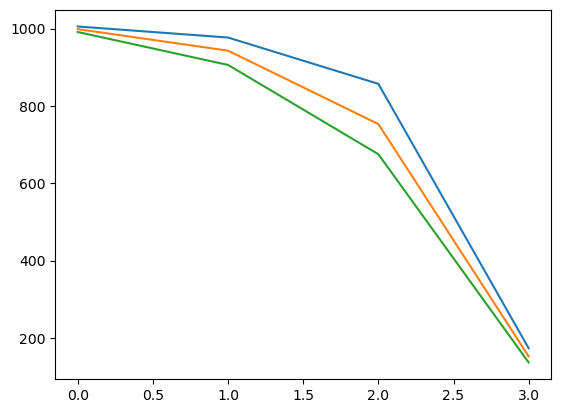

In [7]:
implicit = OneDimReservoir('inputs.yml')
implicit.solve()
implicit.plot()